# Network Visualization

### Load Data

In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from util import import_dataset

address = '../../data/'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'
data, dictionary = import_dataset(address, file_names, train_percent=80, dev_percent=10)

X_raw, y = data.X_train, data.y_train
print('Train data shape: ', X_raw.shape)
print('Train labels shape: ', y.shape)


Train data shape:  (25450, 128, 128, 3)
Train labels shape:  (25450,)


### Preprocess Data

In [3]:
#X_channel = X_raw.reshape(-1, 3) / 255.0
#X_mean = X_channel.mean(0)
#X_std = X_channel.std(0)

#print(X_mean)
#print(X_std)

def deprocess_X(X, rescale=False):
    return (X + data.mean_image) / 255.0

### Load Model

In [4]:
from model import Model, lazy_property

class ResNet(MulticlassModel):
    
    def __init__(self, model_config):
        MulticlassModel.__init__(self, model_config)
    
    @lazy_property
    def prediction(self):
        
        conv_init = tf.layers.conv2d(
                    inputs = self.X_placeholder,
                    filters = 64,
                    kernel_size = [7, 7],
                    strides = 2,
                    padding = "same")
    
        block_input = tf.layers.max_pooling2d(
                    inputs = conv_init,
                    pool_size = [2, 2],
                    strides = 2)
    
        for idl in range(self.config.RS_NdistinctConvLayers) :
            if (idl == 0) :
                firstStride = 1
            else :
                firstStride = 2
            
            conv = tf.layers.conv2d(
                        inputs = block_input,
                        filters = self.config.RS_Nfilters[idl],
                        kernel_size = self.config.RS_kernelSizes[0],
                        strides = firstStride,
                        padding = "same")
            convBN = tf.layers.batch_normalization(
                        conv, 
                        training=self.is_training_placeholder)        
            relu = tf.nn.relu(convBN)
            residual = tf.layers.conv2d(
                        inputs = relu,
                        filters = self.config.RS_Nfilters[idl],
                        kernel_size = self.config.RS_kernelSizes[1],
                        strides = 1,
                        padding = "same")
            residualBN = tf.layers.batch_normalization(
                        residual, 
                        training=self.is_training_placeholder)
            block_input = tf.nn.relu(residualBN)
        
            for ilr in range(self.config.RS_Nlayers[idl] - 1) :
            
                conv = tf.layers.conv2d(
                            inputs = block_input,
                            filters = self.config.RS_Nfilters[idl],
                            kernel_size = self.config.RS_kernelSizes[0],
                            strides = 1,
                            padding = "same")
                convBN = tf.layers.batch_normalization(
                            conv, 
                            training=self.is_training_placeholder)        
                relu = tf.nn.relu(convBN)
                residual = tf.layers.conv2d(
                            inputs = relu,
                            filters = self.config.RS_Nfilters[idl],
                            kernel_size = self.config.RS_kernelSizes[1],
                            strides = 1,
                            padding = "same")
                residualBN = tf.layers.batch_normalization(
                            residual, 
                            training=self.is_training_placeholder)        
                output = block_input + residualBN
                outputBN = tf.layers.batch_normalization(
                            output, 
                            training=self.is_training_placeholder)
                block_input = tf.nn.relu(outputBN)
            
        convRes = tf.layers.batch_normalization(
                    block_input, 
                    training=self.is_training_placeholder)
    
        shape = convRes.get_shape().as_list()
        avgPool = tf.nn.avg_pool(
                    value=convRes, 
                    ksize=[1,shape[1],shape[2],1],
                    strides=[1,1,1,1],
                    padding='VALID')
    
        shape = avgPool.get_shape().as_list()
        avgPool_flat = tf.reshape(avgPool,[-1, shape[1]*shape[2]*shape[3]])

        sbrd_logits = tf.layers.dense(inputs=avgPool_flat, units=20)
        nsfw_logits = tf.layers.dense(inputs=avgPool_flat, units=2)

        return sbrd_logits, nsfw_logits

In [5]:
from config import ModelConfig, TrainConfig

# Reset Graph
tf.reset_default_graph()
loader_address='../../subreddit_classification_parameters/classification_model'

# Create model instance
model_config = ModelConfig(learning_rate=0.003)
model = ResNet(model_config)

# Load Saved Model
session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, loader_address) 

# Saliency Maps

In [10]:
def compute_saliency_maps(X, y, model):
    saliency = None
    # Compute the score of the correct class for each example.
    # This gives a Tensor with shape [N], the number of examples.
    #
    # Note: this is equivalent to scores[np.arange(N), y] we used in NumPy
    # for computing vectorized losses.
    correct_scores = tf.gather_nd(model.prediction, \
                                  tf.stack((tf.range(X.shape[0]), tf.cast(model.y_placeholder, tf.int32)), axis=1))
    ###############################################################################
    # TODO: Implement this function. You should use the correct_scores to compute #
    # the loss, and tf.gradients to compute the gradient of the loss with respect #
    # to the input image stored in model.image.                                   #
    # Use the global sess variable to finally run the computation.                #
    # Note: model.image and model.labels are placeholders and must be fed values  #
    # when you call sess.run().                                                   #
    ###############################################################################
    loss = -tf.reduce_sum(correct_scores)
    dx = tf.gradients(loss, model.X_placeholder)[0]
    saliency_val = tf.reduce_max(tf.abs(dx), axis=-1)
    saliency = session.run(saliency_val, feed_dict={model.X_placeholder:X, model.y_placeholder:y, \
                                                model.is_training_placeholder:False})
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

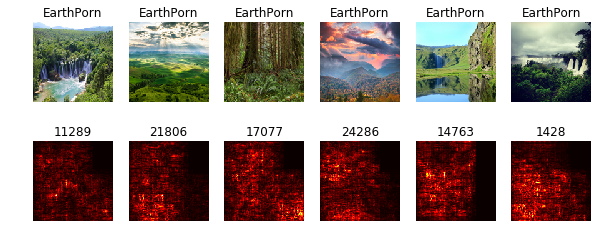

In [33]:
from util import get_class_indices

def show_saliency_maps(X, y, dictionary, mask):
    mask = np.asarray(mask)
    Xm = X[mask]
    ym = y[mask]
    
    saliency = compute_saliency_maps(Xm, ym, model)

    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_X(Xm[i]))
        plt.axis('off')
        class_name = dictionary[ym[i]]
        plt.title(class_name)
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
    plt.show()
    
indices = get_class_indices(data.y_train, dictionary, 6, "EarthPorn")
show_saliency_maps(X_raw, y, dictionary, indices)

In [22]:
print(dictionary)

{0: 'EarthPorn', 1: 'SkyPorn', 2: 'spaceporn', 3: 'MilitaryPorn', 4: 'GunPorn', 5: 'carporn', 6: 'CityPorn', 7: 'ruralporn', 8: 'ArchitecturePorn', 9: 'FoodPorn', 10: 'MoviePosterPorn', 11: 'ArtPorn', 12: 'RoomPorn', 13: 'creepy', 14: 'gonewild', 15: 'PrettyGirls', 16: 'ladybonersgw', 17: 'LadyBoners', 18: 'cats', 19: 'dogpictures'}
